PROJECT PRESENTATION LINK:
https://drive.google.com/file/d/1_XnFZxb5r_bmVhJ8xNhHtP-UhKH6aih2/view?usp=share_link


In [ ]:
!pip install medmnist

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 KB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.5.0-py2.py3-none-any.whl size=116949 sha256=39d1a686042138d910327808ae15e8b54653703299f04c026bd3a355f1e14ba3
  Stored in directory: /root/.cache/pip/wheels/5b/eb/43/7295e71293b218ddfd627f935229bf54af9018add7fbb5aac6
Successfully built fire


In [ ]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO, Evaluator

In [ ]:
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v2.1.0 @ https://github.com/MedMNIST/MedMNIST/


In [ ]:
# Downloading the dataset and saving it automatically.

data_flag = 'dermamnist'

download = True # If it is set to false, then data won't be downloaded.

NUM_EPOCHS = 500
BATCH_SIZE = 128
lr = 0.01

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

In [ ]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

pil_dataset = DataClass(split='train', download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

  0%|          | 0/19725078 [00:00<?, ?it/s]

Using downloaded and verified file: /root/.medmnist/dermamnist.npz
Using downloaded and verified file: /root/.medmnist/dermamnist.npz


In [ ]:
print(train_dataset)
print("===================")
print(test_dataset)

Dataset DermaMNIST (dermamnist)
    Number of datapoints: 7007
    Root location: /root/.medmnist
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'actinic keratoses and intraepithelial carcinoma', '1': 'basal cell carcinoma', '2': 'benign keratosis-like lesions', '3': 'dermatofibroma', '4': 'melanoma', '5': 'melanocytic nevi', '6': 'vascular lesions'}
    Number of samples: {'train': 7007, 'val': 1003, 'test': 2005}
    Description: The DermaMNIST is based on the HAM10000, a large collection of multi-source dermatoscopic images of common pigmented skin lesions. The dataset consists of 10,015 dermatoscopic images categorized as 7 different diseases, formulized as a multi-class classification task. We split the images into training, validation and test set with a ratio of 7:1:2. The source images of 3×600×450 are resized into 3×28×28.
    License: CC BY 4.0
Dataset DermaMNIST (dermamnist)
    Number of datapoints: 2005
    Root location: /roo

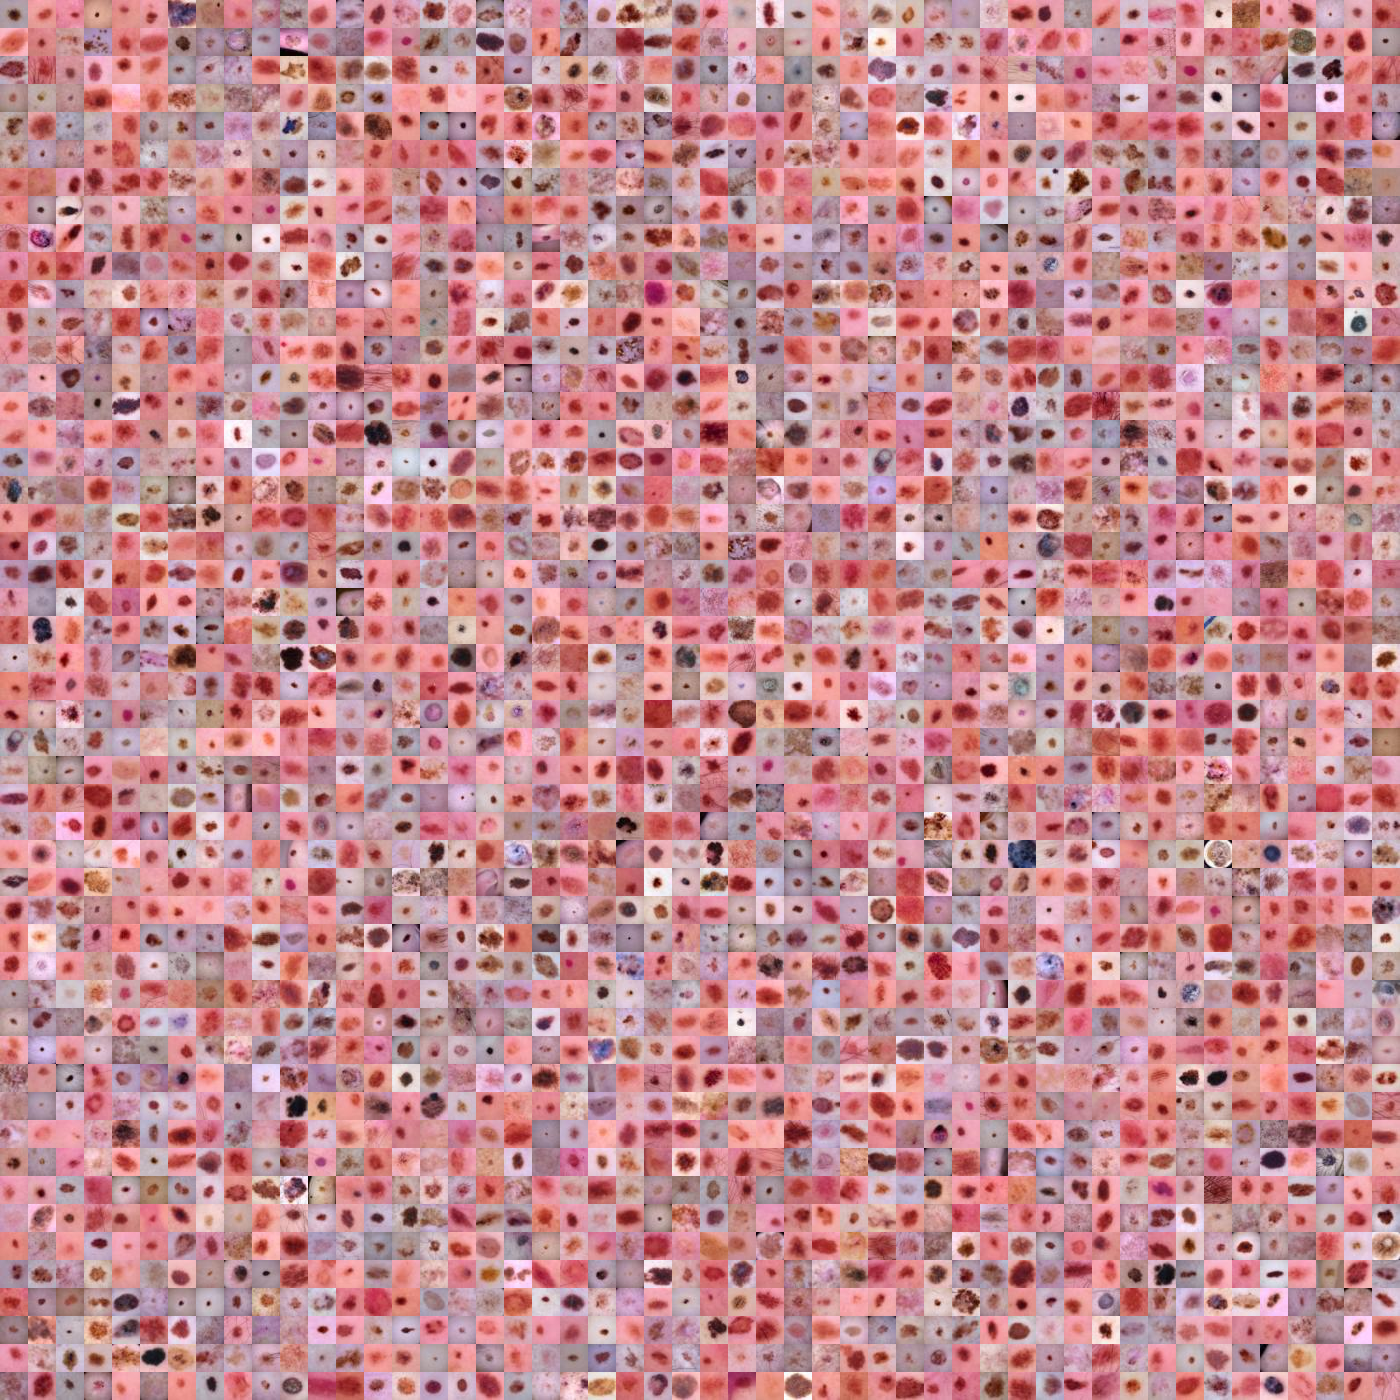

In [ ]:
img=train_dataset.montage(length=50)
img

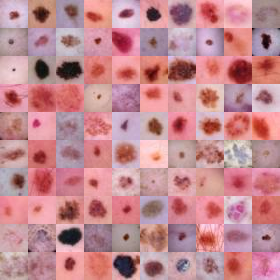

In [ ]:
test_dataset.montage(length=10)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(1600, 50)
        self.fc2 = nn.Linear(50, 7)

    def forward(self, x):
        #print(x.shape)
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        #print(x.shape)
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        #print(x.shape)
        x = x.view(-1, 1600)
        #print(x.shape)
        x = F.relu(self.fc1(x))
        #print(x.shape)
        x = F.dropout(x, training=self.training)
        #print(x.shape)
        x = self.fc2(x)
        #print(x.shape)
        return F.log_softmax(x)

In [ ]:
x=torch.randn(256,3,28,28)
model=Net()
out=model(x)

<ipython-input-11-813c69b8b9d1>:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


In [ ]:
n_epochs=500
log_interval=10
learning_rate = 0.01
momentum = 0.5
batch_size_train = 64
batch_size_test = 1000

In [ ]:
network = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(network.parameters(), lr=learning_rate)

In [ ]:
import torch
import torchvision

In [ ]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [ ]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    target = target.squeeze().long()
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), 'model.pth')
      torch.save(optimizer.state_dict(), 'optimizer.pth')

In [ ]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      target = target.squeeze().long()
      test_loss = criterion(output, target).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [ ]:
# test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

<ipython-input-11-813c69b8b9d1>:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [0/7007 (0%)]	Loss: 1.964059
Train Epoch: 1 [1280/7007 (18%)]	Loss: 1.094791
Train Epoch: 1 [2560/7007 (36%)]	Loss: 0.984091
Train Epoch: 1 [3840/7007 (55%)]	Loss: 1.069103
Train Epoch: 1 [5120/7007 (73%)]	Loss: 1.133683
Train Epoch: 1 [6400/7007 (91%)]	Loss: 1.072742

Test set: Avg. loss: 0.0005, Accuracy: 1341/2005 (67%)

Train Epoch: 2 [0/7007 (0%)]	Loss: 1.038797
Train Epoch: 2 [1280/7007 (18%)]	Loss: 0.984905
Train Epoch: 2 [2560/7007 (36%)]	Loss: 1.076143
Train Epoch: 2 [3840/7007 (55%)]	Loss: 0.921121
Train Epoch: 2 [5120/7007 (73%)]	Loss: 0.814605
Train Epoch: 2 [6400/7007 (91%)]	Loss: 0.820805

Test set: Avg. loss: 0.0004, Accuracy: 1341/2005 (67%)

Train Epoch: 3 [0/7007 (0%)]	Loss: 0.949577
Train Epoch: 3 [1280/7007 (18%)]	Loss: 0.980820
Train Epoch: 3 [2560/7007 (36%)]	Loss: 0.694673
Train Epoch: 3 [3840/7007 (55%)]	Loss: 0.924199
Train Epoch: 3 [5120/7007 (73%)]	Loss: 1.085199
Train Epoch: 3 [6400/7007 (91%)]	Loss: 0.747701

Test set: Avg. loss: 0.0004, Accu

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.plot(test_counter[:-1], test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig